# Public vs. Non-public expenditure on medical conditions

Import necessary libraries

In [44]:
# Defaults:
import os
import pandas as pd
import numpy as np

# Graphics:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3d plots. This import is necessary to have 3D plotting below
import pylab as pl
import seaborn as sns ; sns.set()  # for plot styling

# Stats & regression
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Clustering:
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth

For now, the tables with calculated expenditures have been manually downloaded as CSV tables and been used for the priliminary analyses. For doing this prject, the method of authomatic downloading as developed in the first section of this code will be enhanced and used. To this end, I should figure out how to calculate the expenditure for each condition on the raw data.

In [68]:
#Read read all saved data for different years and assign them to indovidual DataFrames

path = "C:/Users/ali/MEPS_data/All/Mean_expenditure_per_person/"

years = list(range(1996,2016))

# a dictionary of all therapeutic conditions
d = {name: pd.DataFrame() for name in years}

# a sample condition to test the process later on
cancer = pd.DataFrame()

X = pd.DataFrame()
y = pd.DataFrame()
Xn = pd.DataFrame()
yn = pd.DataFrame()

for name, df in d.items():
    file_name= path+"meps-table-"+str(name)+".csv"
    df_name = "df_"+str(name)
    
    # Create the main dataframe; use golbal to be able to add new columns while 
    # reading and cleaning up CSV files
    globals()[df_name] = pd.read_csv(file_name, skiprows=[0], nrows=56)
    
    for j in range(1,6):
        # Cleaning data while reading
        globals()[df_name][globals()[df_name].columns[j]] = \
        globals()[df_name][globals()[df_name].columns[j]].apply(lambda x:str(x).replace('*',''))
        globals()[df_name][globals()[df_name].columns[j]] = \
        globals()[df_name][globals()[df_name].columns[j]].apply(lambda x:str(x).replace('--',''))
        globals()[df_name][globals()[df_name].columns[j]] = \
        globals()[df_name][globals()[df_name].columns[j]].apply(lambda x:str(x).replace(',',''))
        globals()[df_name][globals()[df_name].columns[j]]= \
        globals()[df_name][globals()[df_name].columns[j]].apply(pd.to_numeric, errors='coerce')
    # Final clean up
    globals()[df_name] = globals()[df_name].replace(r'^\s*$', np.nan, regex=True)
    
    # Converitn raw data to per-capita values for Both the expenditure in public and private sectors
    globals()[df_name]['Total_Private'] = \
    globals()[df_name]['Out of pocket'].fillna(0) + \
    globals()[df_name].Private.fillna(0) + globals()[df_name].Other.fillna(0)
    globals()[df_name]['Total_Public'] = \
    globals()[df_name].Medicare.fillna(0) + globals()[df_name].Medicaid.fillna(0)
      
    # Select a sample medical condition to test the process
    cancer = cancer.append(globals()[df_name].loc[4,globals()[df_name].columns[6:8]])
    X = X.append(globals()[df_name]['Total_Private'])
    Xn = Xn.append(globals()[df_name]['Total_Private']*100/sum(globals()[df_name]['Total_Private']))

    # Print(sum(globals()[df_name]['Total_Private'])) to test the process
    y = y.append(globals()[df_name]['Total_Public'])
    yn = yn.append(globals()[df_name]['Total_Public']*100/sum(globals()[df_name]['Total_Public']))


# Clustering

The Goal here is to try to identify the categorzies of therapeutic conditions based on their cost for the society either on the private or public (or both) sectors

In [92]:
def plot_clusters(dataset,num_clusters,clustering_labels,med_cond_list):
    # Assigning results to a DataFrame
    clusters = pd.DataFrame()
    clusters['Medical Condition'] = med_cond_list
    clusters['Expense group'] = clustering_labels
    clusters['Non-Public'] = dataset[:,0]
    clusters['Public'] = dataset[:,1]
    
    # Plotting part
    colors = ['red', 'blue','green','brown','cyan','black']
    for n in range(0,num_clusters):
        xn = clusters['Non-Public'].loc[clusters['Expense group']==n]
        yn = clusters['Public'].loc[clusters['Expense group']==n]
        plt.scatter(xn,yn,color = colors[n])
    plt.xlabel('Non-Public ($)')
    plt.ylabel('Public ($)')
    plt.show()
    return clusters

In [85]:
# Define the dataset:
Xc = np.zeros((56,2))

Xc[:,0] = X.sum()
Xc[:,1] = y.sum()

Xc.shape

(56, 2)

R-squared:  0.4905556223463262


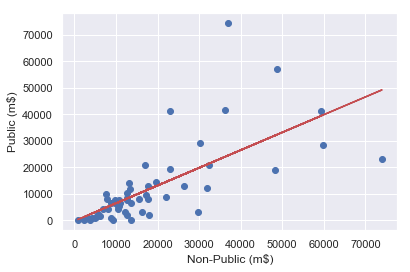

In [86]:
reg = LinearRegression().fit(np.reshape(Xc[:,0],(56,1)), np.reshape(Xc[:,1],(56,1)))
line = reg.coef_*np.reshape(Xc[:,0],(56,1)) + reg.intercept_
print('R-squared: ',r2_score(Xc[:,1], line))
plt.scatter(Xc[:,0], Xc[:,1])
plt.plot(np.reshape(Xc[:,0],(56,1)),line,'r')
plt.xlabel('Non-Public ($)')
plt.ylabel('Public ($)')
plt.show()

Clustering using K-Means

Number of clusters: 2


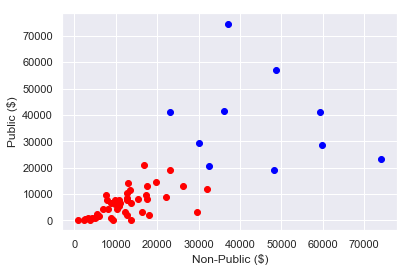

In [87]:
num_clusters = 2
kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(Xc)

print('Number of clusters:', num_clusters)

clusters_kmeans = plot_clusters(Xc,num_clusters,kmeans.labels_,df_1996.iloc[:,0])

Number of clusters: 3


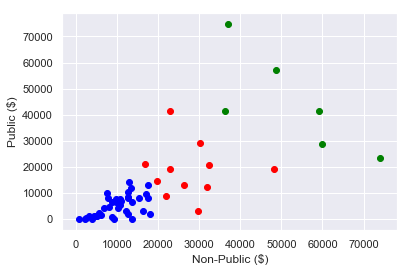

In [88]:
num_clusters = 3
kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(Xc)

print('Number of clusters:', num_clusters)

clusters_kmeans = plot_clusters(Xc,num_clusters,kmeans.labels_,df_1996.iloc[:,0])

Number of clusters: 4


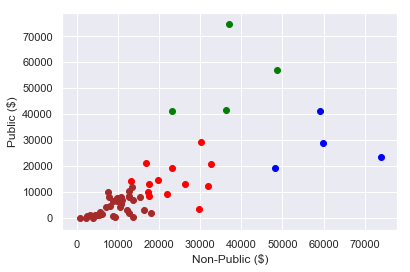

In [90]:
num_clusters = 4
kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(Xc)

print('Number of clusters:', num_clusters)

clusters_kmeans = plot_clusters(Xc,num_clusters,kmeans.labels_,df_1996.iloc[:,0])

Clustering using Mean-Shift

Number of clusters: 6
Bandwidth: 11059.331047185782


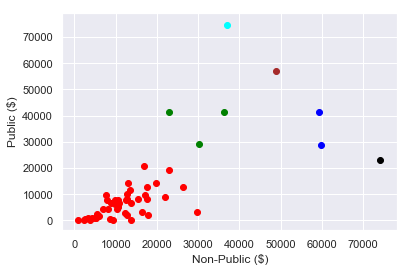

In [93]:
bw = estimate_bandwidth(Xc, quantile=0.2, n_samples=500)
meanshift = MeanShift(bandwidth=bw, bin_seeding=True).fit(Xc)

num_clusters = meanshift.labels_.max()
print('Number of clusters:', num_clusters)
print('Bandwidth:', bw)

clusters_meanshift = plot_clusters(Xc,num_clusters,meanshift.labels_,df_1996.iloc[:,0])